In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib.ticker import MaxNLocator
import json
import collections

query = '''Give me the track genre corresponding to the track number (track in the form: track number|artist name|track name, each track is separated by a backslash). 
Answer in the form: track number|track genre (no more explanation, if there isn't any track info found, track genre should be NO INFO).
Here are the track numbers and their descriptions: '''

In [15]:
class Dataset:
    def __init__(self, dataset):
        bundles = {}
        items = set()
        users = {}
        
        ui_file = open(f'{dataset}/ui_full.txt', 'r')
        for line in ui_file:
            line = line.strip('\n')
            user = line.split(', ')
            users[int(user[0])] = list(set([int(i) for i in user[1:]]))
            items.update(user[1:])

        tmp = len(items)

        bi_file = open(f'{dataset}/bi_full.txt', 'r')

        for line in bi_file:
            line = line.strip('\n')
            bundle = line.split(', ')
            bundles[int(bundle[0])] = [int(i) for i in bundle[1:]]
            items.update(bundle[1:])

        

        

        print(tmp / len(items))

        bi_file.close()
        ui_file.close()
        self.bundles = bundles
        self.items = items
        self.users = users
        self.bundle_with_bundle_size = {}
        self.item_occurence_in_bundle = {}
        self.user_with_user_size = {}
        self.item_occurence_in_user = {}

    def getNumberOfBI(self):
        bi = 0
        for bundle in self.bundles.values():
            bi += len(bundle)
        return bi

    def getNumberOfUI(self):
        ui = 0
        for user in self.users.values():
            ui += len(user)
        return ui

    def _roundTwoDecimals(self, number):
        return int(number * 100) / 100
    
    def _stats_size(self, dictionary, namedict):
        bi = {}
        max_occurence = 0
        size_max = 0
        max_len = 0
        for (b, i) in dictionary.items():
            n = len(i)
            max_len = max(n, max_len)
            if n in bi.keys():
                bi[n] += 1
            else: bi[n] = 1
            if bi[n] > max_occurence:
                max_occurence = bi[n]
                size_max = n
        bi = dict(sorted(bi.items()))
        if namedict == 'bundle':
            print('Max bundle size:', max_len)
        elif namedict == 'user':
            print('Max #I a user interacts with:', max_len)
        plural = 's' if size_max != 1 else ''
        print(f'Size of {namedict} with maximum number of {namedict}s: {max_occurence} ({size_max} {namedict}{plural})')
        return bi

    def _stats_occurence(self, dictionary, namedict):
        ib = {}
        item_occurence = {}
        max_occurence = 0
        idx_max = 0
        max_len = 0
        for array_items in dictionary.values():
            for i in array_items:
                if i in ib.keys():
                    ib[i] += 1
                else: ib[i] = 1
        for (item, occurence) in ib.items():
            max_len = max(occurence, max_len)
            if occurence in item_occurence:
                item_occurence[occurence] += 1
            else: item_occurence[occurence] = 1
            if item_occurence[occurence] > max_occurence:
                max_occurence = item_occurence[occurence]
                idx_max = occurence
        item_occurence = dict(sorted(item_occurence.items()))
        print(f'Max item occurence in a {namedict}: {max_len}')
        plural = 's' if idx_max != 1 else ''
        print(f'#Item occurence with maximum #I in {namedict}: {max_occurence} ({idx_max} item{plural})')
        return item_occurence
    
    def getBasicStats(self):
        num_users = len(self.users)
        num_items = len(self.items)
        num_bundles = len(self.bundles)
        num_ui = self.getNumberOfUI()
        num_bi = self.getNumberOfBI()
        avg_ib = num_bi / num_bundles
        avg_bi = num_bi / num_items
        avg_iu = num_ui / num_users
        avg_ui = num_ui / num_items

        print("#U:", num_users)
        print('#I:', num_items)
        print('#B:', num_bundles)
        print('#B-I:', num_bi)
        print('#U-I:', num_ui)
        print('#Avg.I/B:', self._roundTwoDecimals(avg_ib))
        print('#Avg.B/I:', self._roundTwoDecimals(avg_bi))
        print('#Avg.I/U:', self._roundTwoDecimals(avg_iu))
        print('#Avg.U/I:', self._roundTwoDecimals(avg_ui))

    def _cooccurence(self, data):
        coocc = {}
        for items in data.values():
            n = len(items)
            for i in range(n - 1):
                for j in range(i + 1, n):
                    mini = min(items[i], items[j])
                    maxi = max(items[i], items[j])
                    if (mini, maxi) in coocc.keys():
                        coocc[(mini, maxi)] += 1
                    else: coocc[(mini, maxi)] = 1
                    #print(f'({mini}, {maxi}) - {coocc[(mini, maxi)]}')
                    
        return coocc
    
    def getBundleCooccurence(self):
        return self._cooccurence(self.bundles)
    
    def getUserCooccurence(self):
        return self._cooccurence(self.users)


    def getInteractionStats(self):
        self.bundle_with_bundle_size = self._stats_size(self.bundles, 'bundle')
        self.item_occurence_in_bundle = self._stats_occurence(self.bundles, 'bundle')
        self.user_with_user_size = self._stats_size(self.users, 'user')
        self.item_occurence_in_user = self._stats_occurence(self.users, 'user')

    def plot(self, data, title, xlabel, ylabel, xlim, ylim, width=0.7):
        ax = plt.gca()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        rect = plt.bar(data.keys(), data.values(), width, color='r')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_line(self, data, title, xlabel, ylabel, xlim, ylim, width=0.7):
        ax = plt.gca()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        rect = plt.bar(data.keys(), data.values(), width, color='r')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def getBundleWithBundleSize(self):
        return self.bundle_with_bundle_size
    
    def getItemOccurenceInBundle(self):
        return self.item_occurence_in_bundle
    
    def getUserWithUserSize(self):
        return self.user_with_user_size
    
    def getItemOccurenceInUser(self):
        return self.item_occurence_in_user
    
    def getBundles(self):
        return self.bundles
    
    def getUsers(self):
        return self.users
    
    def getItems(self):
        return self.items

### 1. POG

In [19]:
dataset = 'spotify_sparse'

pog = Dataset(dataset)

# density = pog.getNumberOfUI() / (len(pog.getItems()) * len(pog.getUsers()))
# print(density * 100)

0.3758771827024493


In [22]:

#IBI_pog = pog.getBundleCooccurence()
IUI_pog = dict(sorted(pog.getBundleCooccurence().items(), key=lambda x:x[1], reverse=True))
with open(f"{dataset}/bundle_cooccurence.txt", 'w') as f:
    for key, value in IUI_pog.items():  
        f.write('%s:%s\n' % (key, value))
IBI_histogram = {}

for count in IUI_pog.values():
    if count not in IBI_histogram:
        IBI_histogram[count] = 1
    else: 
        IBI_histogram[count] = IBI_histogram[count] + 1
    


print(sorted(IBI_histogram.items()))

#IUI_pog = pog.getUserCooccurence()

[(1, 17954830), (2, 738937), (3, 180954), (4, 68086), (5, 32403), (6, 18702), (7, 10528), (8, 6396), (9, 4186), (10, 2817), (11, 2408), (12, 1810), (13, 1323), (14, 1046), (15, 756), (16, 623), (17, 466), (18, 382), (19, 301), (20, 280), (21, 264), (22, 172), (23, 156), (24, 143), (25, 123), (26, 114), (27, 111), (28, 90), (29, 92), (30, 87), (31, 86), (32, 73), (33, 50), (34, 47), (35, 52), (36, 46), (37, 40), (38, 33), (39, 35), (40, 20), (41, 25), (42, 39), (43, 24), (44, 17), (45, 21), (46, 25), (47, 15), (48, 19), (49, 17), (50, 16), (51, 18), (52, 11), (53, 14), (54, 17), (55, 18), (56, 13), (57, 9), (58, 8), (59, 8), (60, 9), (61, 14), (62, 8), (63, 6), (64, 5), (65, 5), (66, 7), (67, 4), (68, 3), (69, 4), (70, 1), (71, 4), (72, 3), (73, 2), (74, 4), (76, 2), (77, 1), (78, 2), (79, 2), (80, 1), (81, 1), (83, 1), (97, 1)]


In [4]:
f = open(f'{dataset}/item_info.json', 'r')

data = json.load(f)

In [18]:
with open(f'{dataset}/track_info2.txt', 'w') as f:
    for item in data.items():        
        track_num = item[0]
        artist_name = item[1]['artist_name']
        track_name = item[1]['track_name']
        track_info = f'{track_num}|{artist_name}|{track_name}\n'
        if int(track_num) > 1000:
            f.write(track_info)
        if track_num == '100000': break

In [121]:
import random

bundles = random.sample(range(len(pog.getBundles())), 200)

In [122]:
from googletrans import Translator
translator = Translator()

In [123]:
from PIL import Image
import io
import requests
from IPython.display import display

cnt = 0
for bundle in bundles:
    tracks = bundles[cnt]
    print(f'Bundle {cnt}:')
    for track in pog.getBundles()[tracks]:
        print(f'{track}:')
        info = data[str(track)]
        t = info['title']
        result = translator.translate(t, dest='en').text
        info['title'] = result
        pprint(info)
    cnt += 1





Bundle 0:
10581:
{'cate_id': 'a6cd655d1645f38869be793d5fb194cb',
 'id': '4a743a00ea8102e157b7a6e49847afdb',
 'pic_url': '//img.alicdn.com/imgextra/i2/707902140/TB22Y86e21TBuNjy0FjXXajyXXa_!!707902140-0-beehive-scenes.jpg',
 'title': "Lin Shanshan's new Korean version of the new Korean version of the "
          'full -match nine -point pants loose, thin, small -footed jeans '
          'female'}
13302:
{'cate_id': '126c091a8ff171f694733a624089e68a',
 'id': 'b98ee01f395d009a0cd81ae80475d86f',
 'pic_url': 'http://gw.alicdn.com/imgextra/i2/4/O1CN01lIZbur1Bts6X7F6xa_!!4-2-luban.png',
 'title': 'INS small white shoes female spring wild basic leather student '
          "shoes flat bottom single shoes leather plate shoes women's shoes "
          'casual'}
27187:
{'cate_id': '77c9c3bb3736bf7ba3a3d36b532f6962',
 'id': '2d76c059607857a52a6fa8061d1b061a',
 'pic_url': 'http://gw.alicdn.com/imgextra/i2/19/O1CN01eJhGVh1C0k2xrAErw_!!19-2-luban.png',
 'title': 'Ziqing Hong Kong flavor Chic knitted e

In [19]:
import requests

img_data = requests.get('http://gw.alicdn.com/imgextra/i2/151/O1CN01Co1CBe1CzCKTgyh7G_!!151-2-luban.png').content
with open('image_name.png', 'wb') as handler:
    handler.write(img_data)

19029492.0


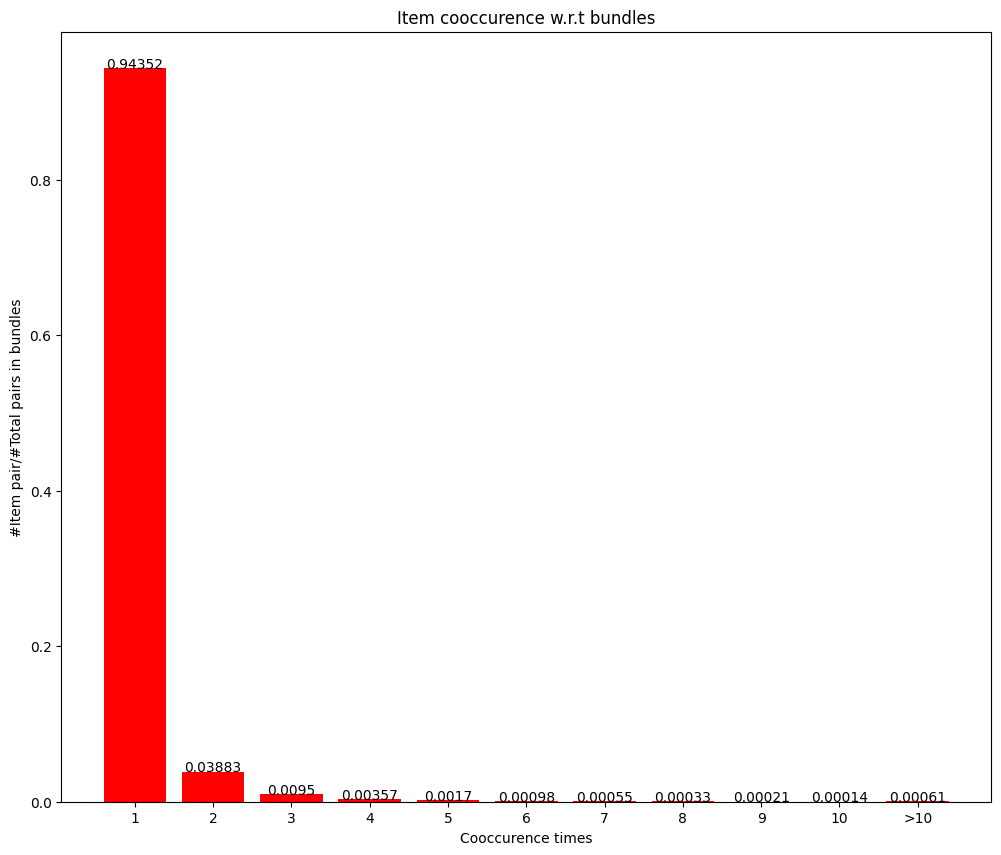

In [25]:
ranges = 1
num_of_range = 10
x_axis = [f'({x * ranges}, {(x + 1) * ranges}]' for x in range(num_of_range)]\
    if ranges != 1 else [f'{x + 1}' for x in range(num_of_range)]
x_axis.append(f'>{num_of_range * ranges}')

#x_axis = ['(0, 50]', '(50, 100]', '(100, 150]', '(150, 200]', '(200, 250]', '(250, 300]', '>300']
#x_axis = ['(0, 50]', '(50, 100]', '(100, 150]', '(150, 200]', '>200']
y_axis = np.zeros((num_of_range + 1,))
for num, time in IBI_histogram.items():
    if (num - 1) // ranges < num_of_range:
        y_axis[(num - 1) // ranges] += time
    else:
        y_axis[num_of_range] += time


num_item = len(pog.getItems())
y_axis_sum = num_item * (num_item - 1) / 2
y_axis_sum = sum(y_axis)
print(y_axis_sum)
for i, data in enumerate(y_axis):
    y_axis[i] /= y_axis_sum
    y_axis[i] = int(y_axis[i] * 100000) / 100000

#y_axis /= (num_item * (num_item - 1) / 2)

plt.figure(figsize=(12, 10))
#plt.figure()
plt.bar(x_axis, y_axis, color='r')
plt.title('Item cooccurence w.r.t bundles')
plt.xlabel('Cooccurence times')
plt.ylabel('#Item pair/#Total pairs in bundles')
for i in range(num_of_range + 1):
    plt.text(i, y_axis[i], y_axis[i], ha='center')
plt.show()




#pog.plot(IBI_histogram, "POG IUI histogram", "Item cooccurence", "#Item pair", [0, 1000], [0, 22000], 5)

In [16]:
pog_dense = Dataset('pog_dense')
IBI_pog_dense = pog_dense.getBundleCooccurence()
IUI_pog_dense = pog_dense.getUserCooccurence()

In [4]:
def process_cooccurence(data, min, max):
    IBI_new = {}
    for ele in data.items():
        if ele[1] >= min and ele[1] <= max:
            IBI_new[ele[0]] = ele[1]
    print('Done IBI_new')
    x = [ele[0] for ele in IBI_new.keys()]
    print('Done x')
    y = [ele[1] for ele in IBI_new.keys()]
    print('Done y')
    z = [ele for ele in IBI_new.values()]
    print('Done z')
    return x, y, z

{0: [28901, 7979, 46572, 692, 24762, 16955, 31933, 44286],
 1: [17569, 47464, 33929, 28907, 15824, 5435, 40382, 35579],
 2: [5924, 42438, 3854],
 3: [6036],
 4: [5488, 32136, 8701, 2583],
 5: [13353, 5738, 5435, 9847],
 6: [88, 48648, 20371, 29300],
 7: [46601, 44284],
 8: [35405, 19149, 19286, 39934, 31352, 2398],
 9: [10969, 17914, 38249],
 10: [25251,
      16900,
      28901,
      4902,
      33898,
      12843,
      38189,
      25390,
      35761,
      33012,
      15004,
      28541,
      41438],
 11: [45673, 26916, 43646],
 12: [37984, 21444, 235, 17037, 20656, 6271],
 13: [13409, 2703, 5173, 38549, 23576, 26680],
 14: [42454, 10887],
 15: [16832, 46018, 23091, 408, 8349],
 16: [12800,
      35138,
      35011,
      27178,
      427,
      13675,
      5517,
      33418,
      22064,
      83,
      12181,
      48056,
      39355,
      31613],
 17: [18752, 40425, 14154, 25231, 12762, 23386, 44283, 16510],
 18: [21322, 15046],
 19: [31704, 22539, 30139, 35814],
 20: [3567

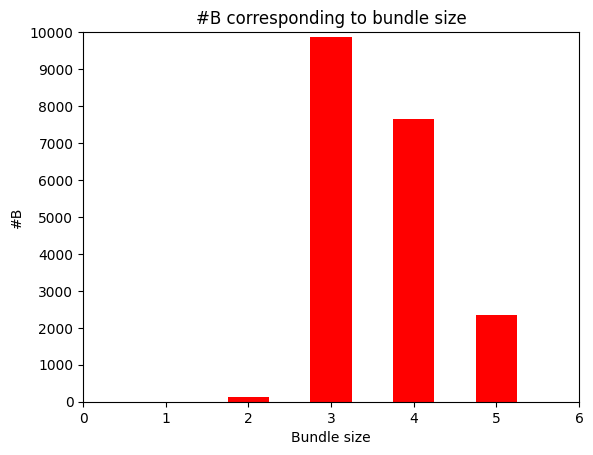

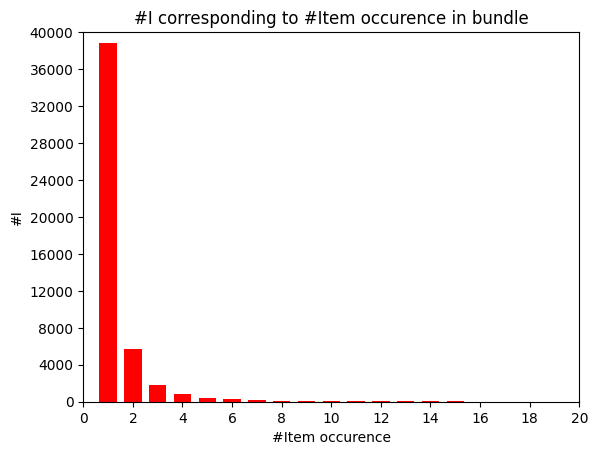

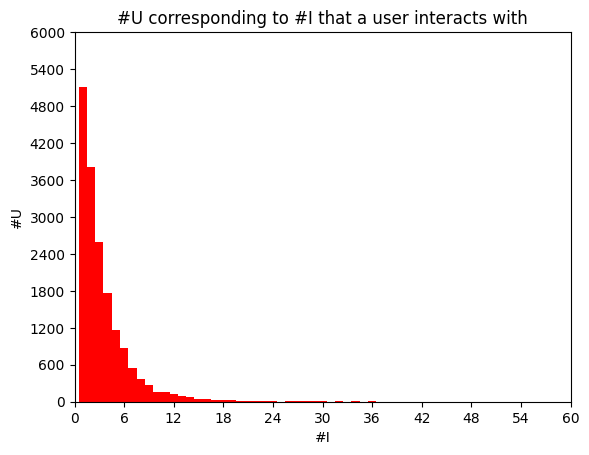

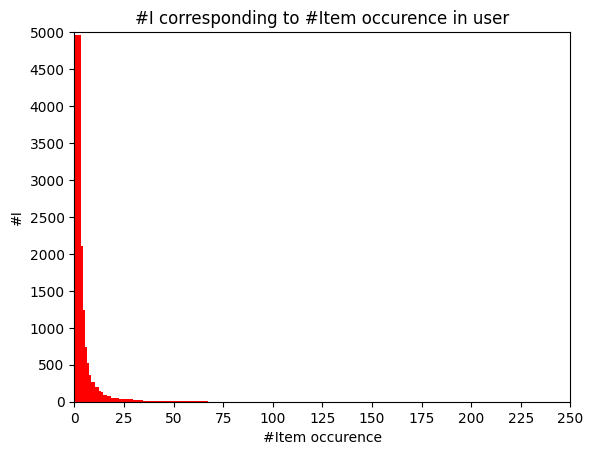

In [18]:
# x, y, z = process_cooccurence(IUI_pog_dense, 101, 500)


# plt.style.use('dark_background')
# fig = plt.figure(figsize=(12, 10))
# #ax = fig.gca()
# plt.scatter(x, y, c=z, s=3, cmap="RdYlBu_r", edgecolor=None)
# plt.xlim([-500, len(pog_dense.getItems()) + 500])
# plt.ylim([-500, len(pog_dense.getItems()) + 500])
# plt.colorbar(label="values")
# plt.show()
pprint(pog.getUsers())

pog.getBasicStats()
pog.getInteractionStats()
pog.plot(pog.getBundleWithBundleSize(), "#B corresponding to bundle size", "Bundle size", "#B", [0, 6], [0, 10000], 0.5)
pog.plot(pog.getItemOccurenceInBundle(), "#I corresponding to #Item occurence in bundle", "#Item occurence", "#I", [0, 20], [0, 40000], 0.7)
pog.plot(pog.getUserWithUserSize(), "#U corresponding to #I that a user interacts with", "#I", "#U", [0, 60], [0, 6000], 1)
pog.plot(pog.getItemOccurenceInUser(), "#I corresponding to #Item occurence in user", "#Item occurence", "#I", [0, 250], [0, 5000], 5)

In [7]:
IBI_histogram = {}

for count in IBI_pog.values():
    if count in IBI_histogram.keys():
        IBI_histogram[count] = 1
    else: 
        IBI_histogram[count] += 1

print(IBI_histogram)
#print(IUI_pog.keys())

KeyError: 1

### 2. POG_dense

In [ ]:
pog_dense = Dataset('pog_dense')
pog_dense.getBasicStats()
pog_dense.getInteractionStats()
pog_dense.plot(pog_dense.getBundleWithBundleSize(), "#B corresponding to bundle size", "Bundle size", "#B", [0, 6], [0, 10000], 0.5)
pog_dense.plot(pog_dense.getItemOccurenceInBundle(), "#I corresponding to #Item occurence in bundle", "#Item occurence", "#I", [0, 105], [0, 40000], 0.7)
pog_dense.plot(pog_dense.getUserWithUserSize(), "#U corresponding to #I that a user interacts with", "#I", "#U", [0, 700], [0, 1900], 1)
pog_dense.plot(pog_dense.getItemOccurenceInUser(), "#I corresponding to #Item occurence in user", "#Item occurence", "#I", [0, 300], [0, 1800], 1)

### 3. Spotify

In [8]:
spotify = Dataset('spotify')
spotify.getBasicStats()
spotify.getInteractionStats()
pprint.pprint(sorted(spotify.getUserWithUserSize().items(), key=lambda x:x[1]))

#U: 118994
#I: 254155
#B: 20000
#B-I: 1268716
#U-I: 36244806
#Avg.I/B: 63.43
#Avg.B/I: 4.99
#Avg.I/U: 304.59
#Avg.U/I: 142.6
Max bundle size: 247
Size of bundle with maximum number of bundles: 319 (20 bundles)
Max item occurence in a bundle: 894
#Item occurence with maximum #I in bundle: 155553 (1 item)
Max #I a user interacts with: 8718
Size of user with maximum number of users: 1045 (1 user)
Max item occurence in a user: 24913
#Item occurence with maximum #I in user: 891 (24 items)
[(1650, 1),
 (1665, 1),
 (1673, 1),
 (1682, 1),
 (1693, 1),
 (1696, 1),
 (1708, 1),
 (1709, 1),
 (1711, 1),
 (1715, 1),
 (1720, 1),
 (1721, 1),
 (1729, 1),
 (1735, 1),
 (1752, 1),
 (1758, 1),
 (1772, 1),
 (1774, 1),
 (1791, 1),
 (1795, 1),
 (1798, 1),
 (1805, 1),
 (1810, 1),
 (1812, 1),
 (1817, 1),
 (1818, 1),
 (1824, 1),
 (1826, 1),
 (1831, 1),
 (1837, 1),
 (1866, 1),
 (1909, 1),
 (1914, 1),
 (1934, 1),
 (1939, 1),
 (1940, 1),
 (1941, 1),
 (1958, 1),
 (1966, 1),
 (1967, 1),
 (1969, 1),
 (1981, 1),
 (1983,

In [9]:
pprint.pprint(sorted(spotify.getUserWithUserSize().items(), key=lambda x:x[1], reverse=True))

[(1, 1045),
 (2, 1004),
 (3, 945),
 (4, 942),
 (7, 912),
 (5, 877),
 (6, 842),
 (11, 835),
 (9, 818),
 (13, 817),
 (10, 802),
 (8, 795),
 (14, 784),
 (12, 762),
 (15, 758),
 (16, 725),
 (17, 714),
 (19, 703),
 (20, 703),
 (18, 687),
 (22, 671),
 (23, 646),
 (29, 646),
 (21, 644),
 (26, 639),
 (24, 632),
 (31, 626),
 (28, 619),
 (27, 608),
 (25, 606),
 (33, 605),
 (32, 576),
 (37, 571),
 (38, 571),
 (30, 565),
 (34, 558),
 (39, 556),
 (35, 555),
 (36, 553),
 (41, 526),
 (43, 520),
 (47, 506),
 (48, 504),
 (51, 501),
 (40, 494),
 (44, 494),
 (49, 493),
 (42, 485),
 (46, 482),
 (52, 482),
 (45, 474),
 (50, 472),
 (57, 464),
 (56, 452),
 (55, 447),
 (58, 447),
 (53, 444),
 (59, 439),
 (54, 423),
 (63, 418),
 (69, 413),
 (60, 412),
 (64, 404),
 (65, 403),
 (71, 398),
 (72, 392),
 (68, 385),
 (66, 384),
 (62, 379),
 (74, 369),
 (61, 367),
 (75, 365),
 (81, 365),
 (67, 355),
 (82, 355),
 (78, 352),
 (79, 348),
 (70, 347),
 (76, 346),
 (86, 344),
 (73, 342),
 (77, 340),
 (92, 331),
 (80, 328),

In [15]:
res = 0

for i, u in spotify.getUserWithUserSize().items():
    res += i * (i - 1) / 2 * u

item_num = len(spotify.getItems())

res /= (item_num * (item_num - 1) / 2)

print(f'{res:,}')

0.5678375005216213


In [ ]:
spotify = Dataset('spotify')
spotify.getBasicStats()
spotify.getInteractionStats()
spotify.plot(spotify.getBundleWithBundleSize(), "#B corresponding to bundle size", "Bundle size", "#B", [0, 250], [0, 350], 1)
spotify.plot(spotify.getItemOccurenceInBundle(), "#I corresponding to #Item occurence in bundle", "#Item occurence", "#I", [0, 100], [0, 160000], 1)
spotify.plot(spotify.getUserWithUserSize(), "#U corresponding to #I that a user interacts with", "#I", "#U", [0, 2000], [0, 1100], 3)
spotify.plot(spotify.getItemOccurenceInUser(), "#I corresponding to #Item occurence in user", "#Item occurence", "#I", [0, 1000], [0, 900], 1)

### 4. Spotify_sparse

In [ ]:
spotify_sparse = Dataset('spotify_sparse')
spotify_sparse.getBasicStats()
spotify_sparse.getInteractionStats()
spotify_sparse.plot(spotify_sparse.getBundleWithBundleSize(), "#B corresponding to bundle size", "Bundle size", "#B", [0, 250], [0, 320], 1)
spotify_sparse.plot(spotify_sparse.getItemOccurenceInBundle(), "#I corresponding to #Item occurence in bundle", "#Item occurence", "#I", [0, 200], [0, 150000], 1)
spotify_sparse.plot(spotify_sparse.getUserWithUserSize(), "#U corresponding to #I that a user interacts with", "#I", "#U", [0, 2000], [0, 1200], 1)
spotify_sparse.plot(spotify_sparse.getItemOccurenceInUser(), "#I corresponding to #Item occurence in user", "#Item occurence", "#I", [0, 1000], [0, 800], 1)